In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.linear_model import LinearRegression
from itertools import combinations
import pandas as pd

# Mutation rate, selection and genetic drift

We want to model the mutation rate dynamics in a population. The population has a constant size. All mutations are independent and their fitness effect is the same. Mutation rate can change through generations (increase or decrease with some probability)

In [2]:
class population():
    
    def __init__(self, nInd, mu=10e-4, s=0.01, plambda=0.1, fd=0.1): 
        #number of individuals
        self.nInd = nInd
        #selection coefficient
        self.s = s
        #initial mutation rate
        self.mu = mu
        #mutation rate of each individual equals mu
        self.mutation_rates = np.array([mu]*self.nInd)
        #parameter lambda determines the possible relative increase/decrease in mutation rate
        self.plambda = plambda
        #fd determines how likely it is to turn from mutator to antimutator
        self.fd = 0.1
        #genotype is described by the number of mutations
        self.genotypes = np.zeros(self.nInd) 
        #to think what we will save here (mutation frequencies? average fitness?)
        self.history = []
        #fitness of genotypes
        self.calculate_fitness()
        #mutators/antimutators (initially all individuals are equal)
        self.mutator_status = np.ones(self.nInd)
    
    def calculate_fitness(self):
        self.fitness = (1 - self.s)**self.genotypes

    def generation(self):
        #turning into mutator/non-mutator
        #probability to turn to antimutator for each individual
        p_antimutator = self.mutation_rates * 0.02 * self.fd
        #probability to turn to mutator for each individual
        p_mutator = self.mutation_rates * 0.02 * (1 - self.fd)
        #each individual can become mutator, antimutator or stay the same
        mutator_classes = []
        for i in range(self.nInd):
            mutator_class = np.random.choice([-1, 0, 1], 1, 
                                             p=[p_antimutator[i], 1-p_mutator[i]-p_antimutator[i], p_mutator[i]])
            mutator_classes.append(mutator_class[0])
        self.mutator_status += np.array(mutator_classes)
        self.mutation_rates = self.mutation_rates + np.array(mutator_classes)*self.mutation_rates*self.plambda
        #mutation (each individual mutates according to its out probability)
        mutations = []
        for i in range(self.nInd):
            #how many mutations happen in this individual
            mutation_n = np.random.poisson(self.mutation_rates[i], 1)
            mutations.append(mutation_n[0])
        self.genotypes += np.array(mutations)
        #fitness re-calculation
        self.calculate_fitness()
        #reproduction (we select nInd for new generation according to fitness values)
        new_indices = np.random.choice(np.arange(self.nInd), self.nInd, 
                                       replace=True, p=np.array(self.fitness)/np.sum(self.fitness))
        #fitness of new generation
        self.fitness = np.take(self.fitness, new_indices)
        #genotypes of new generation
        self.genotypes = np.take(self.genotypes, new_indices)
        #mutation rates of new generation
        self.mutation_rates = np.take(self.mutation_rates, new_indices)
        #mutator status of new generation
        self.mutator_status = np.take(self.mutator_status, new_indices)

    def evolve(self,nGen): 
        for i in range(nGen):
            #one generation = 1)turning into mutator/antimutator 2)mutation process 3)reproduction
            self.generation()
            #we can save some charateristics to check them later
            #self.history.append(len(self.genotypes[self.genotypes >= 1])/self.nInd)
            #self.history.append(np.unique(self.genotypes, return_counts=True))
            #self.history.append(self.fitness.mean())
            self.history.append(self.mutation_rates.mean())

    def plotTraj(self,ax="auto", color='blue'):
        if ax=="auto":
            plt.plot(self.history, label=f'N={self.nInd},s={self.s},mu_init={self.mu}', color=color)
            #plt.axis([0, len(self.history), 0, 1]) 
        #else:
            #plt.axis(ax)
            #ax.plot(self.traj)

In [126]:
#test run
nGen = 500
nInd = 1000
#We create a population and evolve it for nGen
pop = population(nInd, mu=1e-3, s=0.01)
pop.evolve(nGen)

No handles with labels found to put in legend.


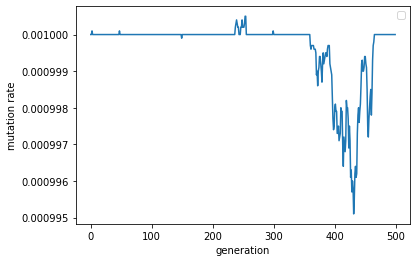

In [127]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(pop.history)
ax.set_xlabel('generation')
ax.set_ylabel('mutation rate')
plt.legend()

In [130]:
#how many mutators/antimutators are there after the evolution
np.unique(pop.mutator_status, return_counts=True)

(array([1.]), array([1000], dtype=int64))

Text(0, 0.5, 'counts')

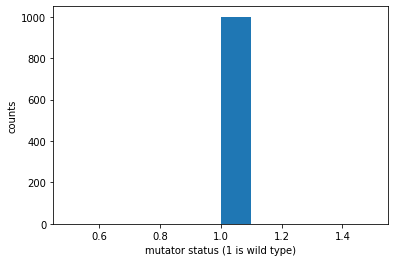

In [131]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.hist(pop.mutator_status)
ax.set_xlabel('mutator status (1 is wild type)')
ax.set_ylabel('counts')

In [135]:
%%time
pop1 = population(nInd=100, s=0.01, mu=1e-5)
pop1.evolve(nGen=1000)
pop2 = population(nInd=100, s=0.01, mu=1e-4)
pop2.evolve(nGen=1000)
pop3 = population(nInd=100, s=0.01, mu=1e-3)
pop3.evolve(nGen=1000)

Wall time: 1min 10s


Text(0, 0.5, 'mutation rate')

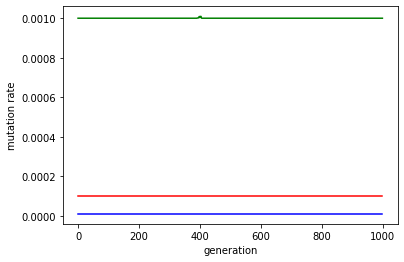

In [136]:
fig, ax = plt.subplots(figsize=(6, 4))

#old stuff - we used to plot the fration of individuals with more than 1 mutations
#pop1.plotTraj()
#pop2.plotTraj(color='red')
#pop3.plotTraj(color='green')
#ax.set_xlabel('generation')
#ax.set_ylabel('individuals with >= 1 mutations')
#plt.legend()

plt.plot(pop1.history, color='blue')
plt.plot(pop2.history, color='red')
plt.plot(pop3.history, color='green')
ax.set_xlabel('generation')
ax.set_ylabel('mutation rate')

In [ ]:
#add saving data in a file

# Mutation accumulation experiment

Mutation-accumulation (MA) experiment is used to experimentally measure the mutation rate. Fifty lines of an E. coli B strain were isolated by picking a single colony (the founder colony) from an agar plate, streaking onto a new plate, incubating overnight at 37 °C, then repeating the pick-streak-incubate procedure (called a growth cycle, GC) for 50 of the resultant colonies. These 50 lines were grown under identical conditions for 300 growth cycles. All fifty lines were derived from a single cell (the founding cell of the founder colony), and were genetically identical except for the mutations that might have occurred during colony expansion (growth
cycle 0). Throughout the mutation accumulation phase, there were ~25 rounds of cell division per growth cycle. Thus each line experienced 300 single cell bottlenecks and ~7,500 rounds of cell division. At growth cycles
0, 100, 120, 200, 250 and 300, sub-samples of each line were frozen in a glycerol-based suspension at -80 °C. These frozen samples were stored for use in fitness assays.

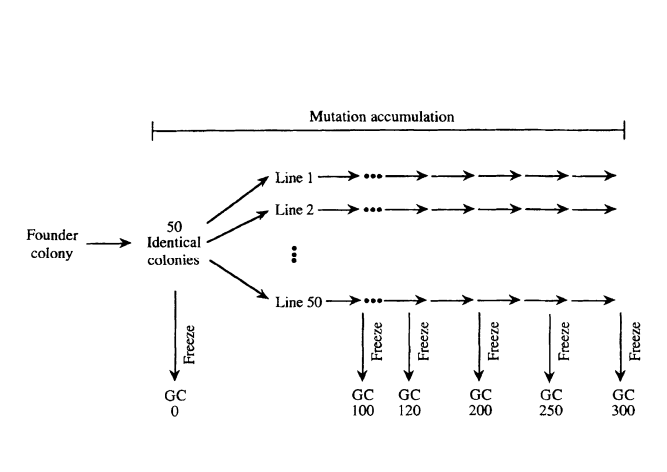

They estimate the mutation rate from the mathematical dependence between the relative fitness and time (circles on a plot below) and between among-line variance in fitness and time (squares on a plot below) 

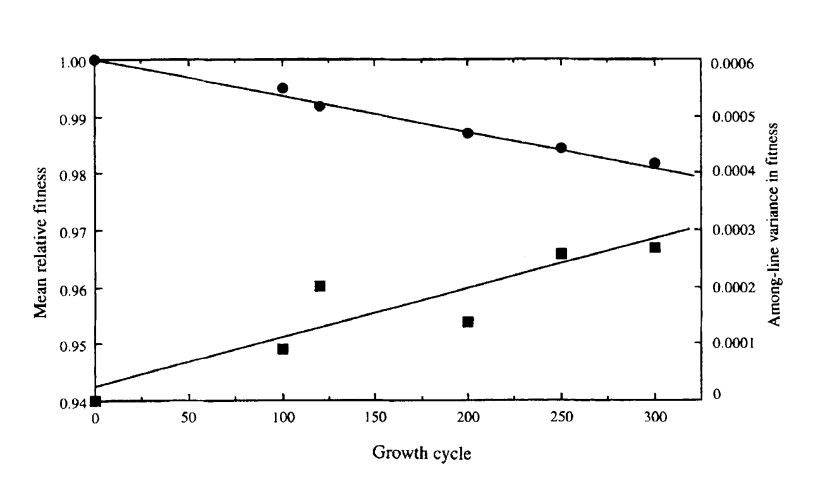

The following is a simulation of MA-experiment

In [5]:
class experiment():
    
    def __init__(self, mu=1e-4, s=0.01, mu1=None, mu2=None, s1=None, s2=None): 
        #selection coefficient
        self.s = s
        #mutation rate
        self.mu = mu
        #here we start from the population of a single individual
        #we describe each genotype simply by number of mutations relative to "wild-type" (wild-type=0)
        #hence, effectively, the genome has an infinite length
        self.genotypes = np.zeros(1) 
        #later we want to track fitness, population size and genotype frequencies through growth cycles
        self.gc_fitness = []
        self.pop_size = []
        self.genotypes_history = []
        self.genotypes_freq = []
        #we can run simulations in mut_partitions_mode when mu is different along the genome
        #another option is selection_partitions_mode when selection coefficient is not constant along the genome  
        self.mut_partitions_mode = False
        self.selection_partitions_mode = False
        
        self.genotypes_history_part1 = []
        self.genotypes_history_part2 = []
        self.genotypes_freq_part1 = []
        self.genotypes_freq_part2 = []
        
        if (mu1 is not None) and (mu2 is not None):
            self.mut_partitions_mode = True
            self.mu1 = mu1
            self.mu2 = mu2
            #now genotypes are described by two numbers: number of mutations in each part of a genome
            self.genotypes_part1 = np.zeros(1)
            self.genotypes_part2 = np.zeros(1)
            
        if (s1 is not None) and (s2 is not None):
            self.selection_partitions_mode = True
            self.s1 = s1
            self.s2 = s2
            #now genotypes are described by two numbers: number of mutations in each part of a genome
            self.genotypes_part1 = np.zeros(1)
            self.genotypes_part2 = np.zeros(1)

        #we calculate initial fitness of genotypes
        self.calculate_fitness()
    
    def calculate_fitness(self):
        if not self.selection_partitions_mode:
            #we assume here that all mutations are equally deleterious and independent
            #all mutations reduce fitness by s (i.e. fitness of a genotype with n mutations is (1-s)**n)
            self.fitness = (1 - self.s)**self.genotypes
        else:
            #mutations have different effects in different parts of a genome
            #these effects are described by selection coefficients s1 and s2
            self.fitness = ((1 - self.s1)**self.genotypes_part1) * ((1 - self.s2)**self.genotypes_part2)
        
    def mutation_process(self):
        if self.selection_partitions_mode or self.mut_partitions_mode:
            #we need to mutate two parts of a genome separately
            #mutations arise according to Poisson process with mean=mu
            if self.mut_partitions_mode:
                mutations_part1 = np.random.poisson(self.mu1/2, len(self.genotypes))
                mutations_part2 = np.random.poisson(self.mu2/2, len(self.genotypes))
            else:
                mutations_part1 = np.random.poisson(self.mu/2, len(self.genotypes))
                mutations_part2 = np.random.poisson(self.mu/2, len(self.genotypes))
            #we describe genotypes of two parts separately and together (in self.genotypes we don't distinguish)
            self.genotypes_part1 += mutations_part1
            self.genotypes_part2 += mutations_part2
            self.genotypes += mutations_part1
            self.genotypes += mutations_part2
        else:
            #genome is homogeneous
            mutations = np.random.poisson(self.mu, len(self.genotypes))
            self.genotypes += mutations
    
    def growth_process(self):
        #here we implement the growth of the population
        #we define all genotypes in a population and their counts
        #we make them reproduce according to their fitness
        #population is described with loistic growth, the carrying capacity of the environment is K
        K = 10000
        new_genotypes = []
        if self.selection_partitions_mode or self.mut_partitions_mode:
            genome = np.vstack([self.genotypes_part1, self.genotypes_part2])
            genotypes, idx, counts = np.unique(genome, axis=1, return_counts=True, return_index=True)
            for genotype, index, count in zip(genotypes.T, idx, counts):
                growth_rate = self.fitness[index]
                n_offspring = growth_rate * count * (1 - len(self.genotypes)/K)
                new_genotypes.append(np.tile(genotype, [round(count + n_offspring), 1]))
            self.genotypes = np.vstack(new_genotypes).sum(axis=1)
            self.genotypes_part1 = np.vstack(new_genotypes)[:, 0]
            self.genotypes_part2 = np.vstack(new_genotypes)[:, 1]
        else:
            genotypes, idx, counts = np.unique(self.genotypes, return_counts=True, return_index=True)
            for genotype, index, count in zip(genotypes, idx, counts):
                growth_rate = self.fitness[index]
                n_offspring = growth_rate * count * (1 - len(self.genotypes)/K)
                new_genotypes.append(np.repeat(genotype, round(count + n_offspring)))
            self.genotypes = np.hstack(new_genotypes)
                    
    def generation(self):
        #At each generation our population goes through mutation and growth
        #mutation (at this stage each genotype can gain a mutation)
        self.mutation_process()
        #we re-calculate fitness for mutants
        self.calculate_fitness()
        #population grows (reproduction stage)
        self.growth_process()

    def evolve(self, nGrowthCyc=300, nDivPerCyc=25):
        for gc in range(nGrowthCyc):
            #we pick up a founder cell (one random individual from a population)
            if gc >= 1:
                random_idx = np.random.choice(len(self.genotypes), 1)
                self.genotypes = self.genotypes[random_idx]
                if self.selection_partitions_mode or self.mut_partitions_mode:
                    self.genotypes_part1 = self.genotypes_part1[random_idx]
                    self.genotypes_part2 = self.genotypes_part2[random_idx]
                self.calculate_fitness()
            #growth phase (we put the selected cell on a plate and let it grow for nDivPerCyc generations)
            #on each step we save all intersting parameters
            for i in range(nDivPerCyc):
                self.generation()
                self.pop_size.append(len(self.genotypes))
                self.genotypes_history.append(self.genotypes.mean())
                self.genotypes_freq.append((gc, i, np.unique(self.genotypes, return_counts=True)[0],
                                           np.unique(self.genotypes, return_counts=True)[1]))
                if self.selection_partitions_mode or self.mut_partitions_mode:
                    self.genotypes_history_part1.append(self.genotypes_part1.mean())
                    self.genotypes_history_part2.append(self.genotypes_part2.mean())
                    self.genotypes_freq_part1.append(np.unique(self.genotypes_part1, return_counts=True))
                    self.genotypes_freq_part2.append(np.unique(self.genotypes_part2, return_counts=True))
            self.gc_fitness.append(self.fitness.mean())

# The baseline experiment

In [37]:
#How many times we will repeat the experiment (50 lines in the original paper)
nLines = 50
#Number of growth cycles (300 cycles in the original paper)
nGrowthCyc = 300
#Number of cell divisions per cycle (25 in the original paper)
nDivPerCyc = 25

In [131]:
mu = 1e-4
s = 0.01

In [142]:
%%time
experiment_results = []
average_muts = []
mut_freq = []
#we run a separate experiment for each line and remember the fitness measurements
for line in tqdm(range(nLines)):
    exp = experiment(mu=mu, s=s)
    exp.evolve(nGrowthCyc=300, nDivPerCyc=nDivPerCyc)
    #we save fitness measurements for each line at each growth cycle
    experiment_results.append(exp.gc_fitness)
    #save genotypes numbers
    #line_genotypes[line] = exp.genotypes_history
    average_muts.append(exp.genotypes_history)
    mut_freq.append(exp.genotypes_freq)
experiment_results = np.array(experiment_results)
average_muts = np.array(average_muts)


Wall time: 4min 13s


In [253]:
#We have a matrix of shape (number of lines x number of growth cycles)
experiment_results.shape, average_muts.shape

((50, 300), (50, 7500))

Text(0, 0.5, 'Mean relative fitness')

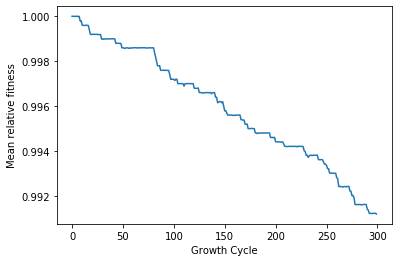

In [6]:
#Mean fitness among lines per growth cycle
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(nGrowthCyc), experiment_results.mean(axis=0))
ax.set_xlabel('Growth Cycle')
ax.set_ylabel('Mean relative fitness')

In [394]:
model = LinearRegression()
x = np.arange(nGrowthCyc)
y = experiment_results.mean(axis=0)
model.fit(x.reshape(-1, 1), y)
R = model.coef_
model.intercept_ , model.coef_

(0.9993346461093875, array([-2.19763641e-05]))

Text(0, 0.5, 'Mean relative fitness')

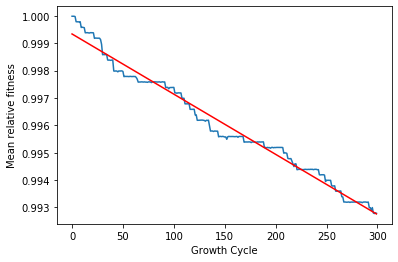

In [395]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(nGrowthCyc), experiment_results.mean(axis=0))
plt.plot(x, (model.intercept_ + model.coef_*x).flatten(), color='red')
ax.set_xlabel('Growth Cycle')
ax.set_ylabel('Mean relative fitness')

Text(0, 0.5, 'Among-line variance in fitness')

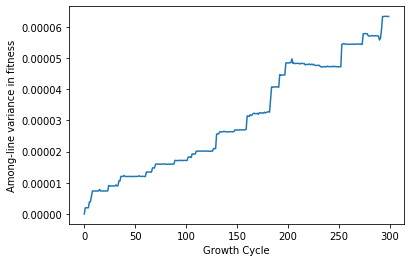

In [211]:
#Variance in fitness among lines per growth cycle
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(nGrowthCyc), experiment_results.std(axis=0)**2)
ax.set_xlabel('Growth Cycle')
ax.set_ylabel('Among-line variance in fitness')

In [212]:
model = LinearRegression()
x = np.arange(nGrowthCyc)
y = experiment_results.std(axis=0)**2
model.fit(x.reshape(-1, 1), y)
V = model.coef_
model.intercept_ , model.coef_

(8.443040326853741e-07, array([2.00228001e-07]))

Text(0, 0.5, 'Among-line variance in fitness')

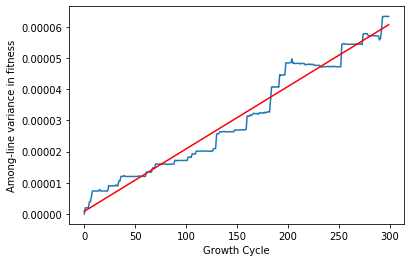

In [190]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(nGrowthCyc), experiment_results.std(axis=0)**2)
plt.plot(x, (model.intercept_ + model.coef_*x).flatten(), color='red')
ax.set_xlabel('Growth Cycle')
ax.set_ylabel('Among-line variance in fitness')

In [256]:
average_muts.mean(axis=0).shape

(7500,)

Text(0, 0.5, 'Average number of mutations in a genome (among lines)')

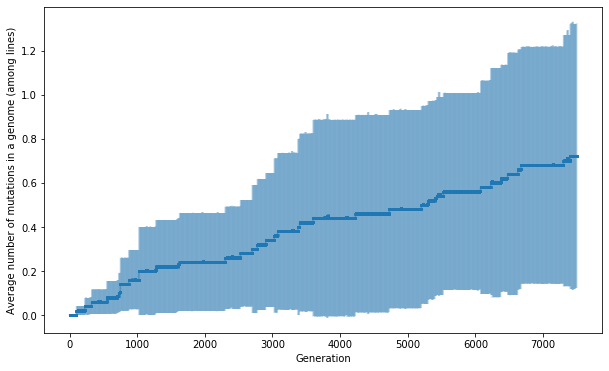

In [266]:
#Average number of mutations in a genome
fig, ax = plt.subplots(figsize=(10, 6))
plt.errorbar(x=np.arange(average_muts.shape[1]), y=average_muts.mean(axis=0), 
             yerr=average_muts.std(axis=0)**2, alpha=0.5, marker='s', ms=2, elinewidth=0.1)
ax.set_xlabel('Generation')
ax.set_ylabel('Average number of mutations in a genome (among lines)')

In [259]:
#Estimate of mutation rate from a plot
0.7/7500

9.333333333333333e-05

In [267]:
#estimates of mutation rate and selection (formulae from the paper)
(R**2)/V, V/R

(array([0.00286997]), array([-0.00835264]))

In [268]:
#True values
exp.mu, exp.s

(0.0001, 0.01)

In [269]:
#Raw coefficients (R is supposed to be U*<s>, V is supposed to be U*var(<s^2>))
R, V

(array([-2.39718335e-05]), array([2.00228001e-07]))

In [ ]:
#run with different parameters
for mu in [0.01, 0.001, 0.0001]:
    for s in [0.1, 0.01, 0.001]:
        experiment_results = []
        average_muts = []
        #we run a separate experiment for each line and remember the fitness measurements
        for line in tqdm(range(nLines)):
            exp = experiment(mu=mu, s=s)
            exp.evolve(nGrowthCyc=300, nDivPerCyc=nDivPerCyc)
            #we save fitness measurements for each line at each growth cycle
            experiment_results.append(exp.gc_fitness)
            #save genotypes numbers
            #line_genotypes[line] = exp.genotypes_history
            average_muts.append(exp.genotypes_history)
        experiment_results = np.array(experiment_results)
        average_muts = np.array(average_muts)
        np.save(f'data/baseline_experiment_mu_{mu}_s_{s}.npy', experiment_results)
        np.save(f'data/baseline_experiment_mut_counts_mu_{mu}_s_{s}.npy', average_muts)

# Different mutation rates along the genome 

Here we assume that in our experiment different parts of a genome mutate with different rates (we consider two parts with mutation rate mu1 and mu2)

In [13]:
#a function to easily calculate the regression coefficient for our calculations
def calculate_regression_coefficient(x, y):
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y)
    return model.coef_

In [14]:
s=0.01
mu1=1e-4
mu2=1e-2

In [15]:
%%time
mut_parts_experiment_results = []
mut_parts_average_muts = []
average_muts_part1 = []
average_muts_part2 = []

#we run a separate experiment for each line and remember the fitness measurements
for line in tqdm(range(nLines)):
    exp = experiment(s=s, mu1=mu1, mu2=mu2)
    exp.evolve(nGrowthCyc=300, nDivPerCyc=nDivPerCyc)
    #we save fitness measurements for each line at each growth cycle
    mut_parts_experiment_results.append(exp.gc_fitness)
    #save mutation numbers
    mut_parts_average_muts.append(exp.genotypes_history)
    #save mutation numbers for partitions separately
    average_muts_part1.append(exp.genotypes_history_part1)
    average_muts_part2.append(exp.genotypes_history_part2)

mut_parts_experiment_results = np.array(mut_parts_experiment_results)
mut_parts_average_muts = np.array(mut_parts_average_muts)
average_muts_part1 = np.array(average_muts_part1)
average_muts_part2 = np.array(average_muts_part2)


Wall time: 14min 49s


In [16]:
np.save(f'data/different_mus_experiment_mu1{mu1}_mu2{mu2}.npy', mut_parts_experiment_results)
np.save(f'data/different_mus_experiment_mut_counts_mu1{mu1}_mu2{mu2}.npy', mut_parts_average_muts)
np.save(f'data/different_mus_experiment_mut_counts_part1_mu1{mu1}_mu2{mu2}.npy', average_muts_part1)
np.save(f'data/different_mus_experiment_mut_counts_part2_mu1{mu1}_mu2{mu2}.npy', average_muts_part2)

Text(0, 0.5, 'Mean relative fitness')

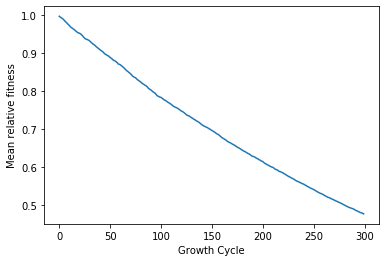

In [362]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(nGrowthCyc), mut_parts_experiment_results.mean(axis=0))
ax.set_xlabel('Growth Cycle')
ax.set_ylabel('Mean relative fitness')

In [363]:
R = calculate_regression_coefficient(np.arange(nGrowthCyc), mut_parts_experiment_results.mean(axis=0))
R

array([-0.00173886])

Text(0, 0.5, 'Among-line variance in fitness')

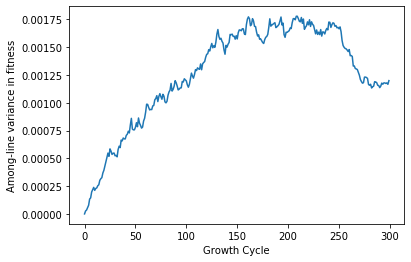

In [364]:
#Variance in fitness among lines per growth cycle
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(nGrowthCyc), mut_parts_experiment_results.std(axis=0)**2)
ax.set_xlabel('Growth Cycle')
ax.set_ylabel('Among-line variance in fitness')

In [365]:
V = calculate_regression_coefficient(np.arange(nGrowthCyc), mut_parts_experiment_results.std(axis=0)**2)
V

array([3.66329427e-06])

Text(0, 0.5, 'Average number of mutations in a genome (among lines)')

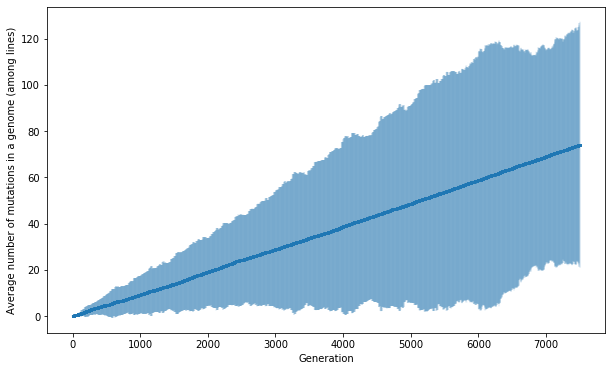

In [366]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.errorbar(x=np.arange(mut_parts_average_muts.shape[1]), y=mut_parts_average_muts.mean(axis=0), 
             yerr=mut_parts_average_muts.std(axis=0)**2, alpha=0.5, marker='s', ms=2, elinewidth=0.1)
ax.set_xlabel('Generation')
ax.set_ylabel('Average number of mutations in a genome (among lines)')

In [367]:
70/7500

0.009333333333333334

In [281]:
(R**2)/V, V/R

(array([0.85180577]), array([-0.00207862]))

Text(0, 0.5, 'Average number of mutations in a genome (among lines)')

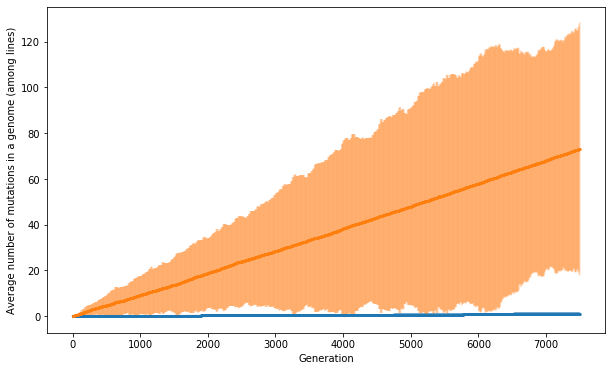

In [369]:
#The same plot for ywo parts of the genome separately
fig, ax = plt.subplots(figsize=(10, 6))
plt.errorbar(x=np.arange(average_muts_part1.shape[1]), y=average_muts_part1.mean(axis=0), 
             yerr=average_muts_part1.std(axis=0)**2, alpha=0.5, marker='s', ms=1, elinewidth=0.1)
plt.errorbar(x=np.arange(average_muts_part2.shape[1]), y=average_muts_part2.mean(axis=0), 
             yerr=average_muts_part2.std(axis=0)**2, alpha=0.5, marker='s', ms=1, elinewidth=0.1)
ax.set_xlabel('Generation')
ax.set_ylabel('Average number of mutations in a genome (among lines)')

In [ ]:
#run with different parameters
s = 0.01
for mu1, mu2 in combinations([0.01, 0.001, 0.0001], 2):
    mut_parts_experiment_results = []
    mut_parts_average_muts = []
    average_muts_part1 = []
    average_muts_part2 = []

    #we run a separate experiment for each line and remember the fitness measurements
    for line in tqdm(range(nLines)):
        exp = experiment(s=s, mu1=mu1, mu2=mu2)
        exp.evolve(nGrowthCyc=300, nDivPerCyc=nDivPerCyc)
        #we save fitness measurements for each line at each growth cycle
        mut_parts_experiment_results.append(exp.gc_fitness)
        #save mutation numbers
        mut_parts_average_muts.append(exp.genotypes_history)
        #save mutation numbers for partitions separately
        average_muts_part1.append(exp.genotypes_history_part1)
        average_muts_part2.append(exp.genotypes_history_part2)

    mut_parts_experiment_results = np.array(mut_parts_experiment_results)
    mut_parts_average_muts = np.array(mut_parts_average_muts)
    average_muts_part1 = np.array(average_muts_part1)
    average_muts_part2 = np.array(average_muts_part2)
    
    np.save(f'clean_data/different_mus_experiment_mu1_{mu1}_mu2_{mu2}_s_{s}.npy', mut_parts_experiment_results)
    np.save(f'clean_data/different_mus_experiment_mut_counts_mu1_{mu1}_mu2_{mu2}_s_{s}.npy', mut_parts_average_muts)
    np.save(f'clean_data/different_mus_experiment_mut_counts_part1_mu1_{mu1}_mu2_{mu2}_s_{s}.npy', average_muts_part1)
    np.save(f'clean_data/different_mus_experiment_mut_counts_part2_mu1_{mu1}_mu2_{mu2}_s_{s}.npy', average_muts_part2)
    
    with open(f'clean_data/different_mus_experiment_sequencing_mu1_{mu1}_mu2_{mu2}_s_{s}.csv', 'w') as f:
        f.write(f'line,GC,DivCyc,genotype,counts\n')
        counter = 0
        for line_freq in mut_freq:
            for e in line_freq:
                gc, divcyc, gen, counts = e
                for i in range(len(gen)):
                    f.write(f'line{counter},{gc},{divcyc},{gen[i]},{counts[i]}\n')
            counter += 1

# Different selection coefficients along the genome

Here we assume that in our experiment mutations in different parts of a genome have different selection coefficients (we consider two parts with selection coefficients s1 and s2)

In [17]:
mu=1e-4
s1=0.001
s2=0.01

In [18]:
%%time
sel_parts_experiment_results = []
sel_parts_average_muts = []
average_muts_part1_s1 = []
average_muts_part2_s2 = []

#we run a separate experiment for each line and remember the fitness measurements
for line in tqdm(range(nLines)):
    exp = experiment(mu=mu, s1=s1, s2=s2)
    exp.evolve(nGrowthCyc=300, nDivPerCyc=nDivPerCyc)
    #we save fitness measurements for each line at each growth cycle
    sel_parts_experiment_results.append(exp.gc_fitness)
    #save mutation numbers
    sel_parts_average_muts.append(exp.genotypes_history)
    #save mutation numbers for partitions separately
    average_muts_part1_s1.append(exp.genotypes_history_part1)
    average_muts_part2_s2.append(exp.genotypes_history_part2)

sel_parts_experiment_results = np.array(sel_parts_experiment_results)
sel_parts_average_muts = np.array(sel_parts_average_muts)
average_muts_part1_s1 = np.array(average_muts_part1_s1)
average_muts_part2_s2 = np.array(average_muts_part2_s2)


Wall time: 12min 31s


In [19]:
np.save(f'data/different_s_experiment_s1{s1}_s2{s2}.npy', sel_parts_experiment_results)
np.save(f'data/different_s_experiment_mut_counts_s1{s1}_s2{s2}.npy', sel_parts_average_muts)
np.save(f'data/different_s_experiment_mut_counts_part1_s1{s1}_s2{s2}.npy', average_muts_part1_s1)
np.save(f'data/different_s_experiment_mut_counts_part2_s1{s1}_s2{s2}.npy', average_muts_part2_s2)

Text(0, 0.5, 'Mean relative fitness')

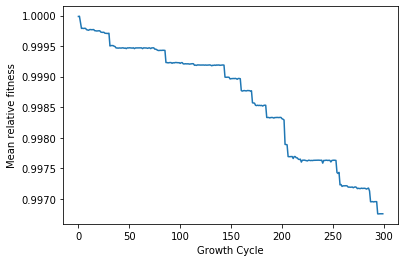

In [384]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(nGrowthCyc), sel_parts_experiment_results.mean(axis=0))
ax.set_xlabel('Growth Cycle')
ax.set_ylabel('Mean relative fitness')

In [385]:
R = calculate_regression_coefficient(np.arange(nGrowthCyc), sel_parts_experiment_results.mean(axis=0))
R

array([-1.0366452e-05])

Text(0, 0.5, 'Among-line variance in fitness')

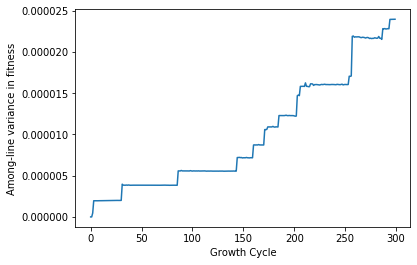

In [386]:
#Variance in fitness among lines per growth cycle
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(nGrowthCyc), sel_parts_experiment_results.std(axis=0)**2)
ax.set_xlabel('Growth Cycle')
ax.set_ylabel('Among-line variance in fitness')

In [387]:
V = calculate_regression_coefficient(np.arange(nGrowthCyc), sel_parts_experiment_results.std(axis=0)**2)
V

array([7.56199902e-08])

In [388]:
(R**2)/V, V/R

(array([0.0014211]), array([-0.00729468]))

Text(0, 0.5, 'Average number of mutations in a genome (among lines)')

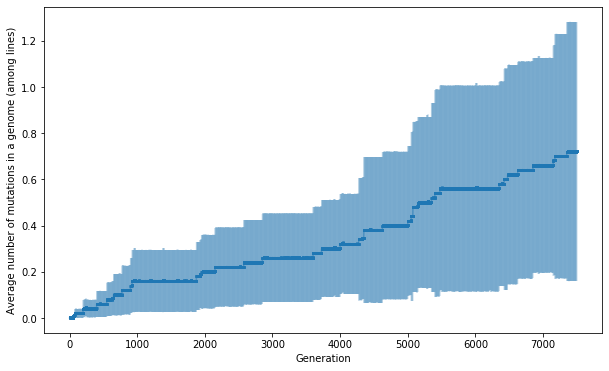

In [389]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.errorbar(x=np.arange(sel_parts_average_muts.shape[1]), y=sel_parts_average_muts.mean(axis=0), 
             yerr=sel_parts_average_muts.std(axis=0)**2, alpha=0.5, marker='s', ms=2, elinewidth=0.1)
ax.set_xlabel('Generation')
ax.set_ylabel('Average number of mutations in a genome (among lines)')

Text(0, 0.5, 'Average number of mutations in a genome (among lines)')

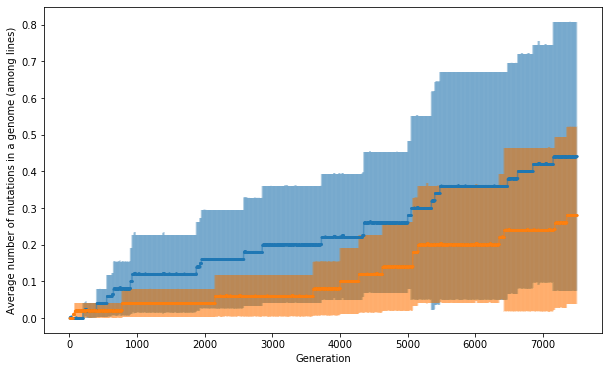

In [391]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.errorbar(x=np.arange(average_muts_part1_s1.shape[1]), y=average_muts_part1_s1.mean(axis=0), 
             yerr=average_muts_part1_s1.std(axis=0)**2, alpha=0.5, marker='s', ms=1, elinewidth=0.1)
plt.errorbar(x=np.arange(average_muts_part2_s2.shape[1]), y=average_muts_part2_s2.mean(axis=0), 
             yerr=average_muts_part2_s2.std(axis=0)**2, alpha=0.5, marker='s', ms=1, elinewidth=0.1)
ax.set_xlabel('Generation')
ax.set_ylabel('Average number of mutations in a genome (among lines)')

In [ ]:
#run with different parameters
mu = 0.01
for s1, s2 in combinations([0.1, 0.01, 0.001], 2):
    sel_parts_experiment_results = []
    sel_parts_average_muts = []
    average_muts_part1_s1 = []
    average_muts_part2_s2 = []

    #we run a separate experiment for each line and remember the fitness measurements
    for line in tqdm(range(nLines)):
        exp = experiment(mu=mu, s1=s1, s2=s2)
        exp.evolve(nGrowthCyc=300, nDivPerCyc=nDivPerCyc)
        #we save fitness measurements for each line at each growth cycle
        sel_parts_experiment_results.append(exp.gc_fitness)
        #save mutation numbers
        sel_parts_average_muts.append(exp.genotypes_history)
        #save mutation numbers for partitions separately
        average_muts_part1_s1.append(exp.genotypes_history_part1)
        average_muts_part2_s2.append(exp.genotypes_history_part2)

    sel_parts_experiment_results = np.array(sel_parts_experiment_results)
    sel_parts_average_muts = np.array(sel_parts_average_muts)
    average_muts_part1_s1 = np.array(average_muts_part1_s1)
    average_muts_part2_s2 = np.array(average_muts_part2_s2)
    
    np.save(f'data/different_s_experiment_s1_{s1}_s2_{s2}_mu_{mu}.npy', sel_parts_experiment_results)
    np.save(f'data/different_s_experiment_mut_counts_s1_{s1}_s2_{s2}_mu_{mu}.npy', sel_parts_average_muts)
    np.save(f'data/different_s_experiment_mut_counts_part1_s1_{s1}_s2_{s2}_mu_{mu}.npy', average_muts_part1_s1)
    np.save(f'data/different_s_experiment_mut_counts_part2_s1_{s1}_s2_{s2}_mu_{mu}.npy', average_muts_part2_s2)

# Pictures

In [22]:
experiment_results = np.load('data/baseline_experiment.npy')
average_muts = np.load('data/baseline_experiment_mut_counts.npy')
mut_parts_experiment_results = np.load('data/different_mus_experiment_mu1_0.0001_mu2_0.01.npy')
mut_parts_average_muts = np.load('data/different_mus_experiment_mut_counts_mu1_0.0001_mu2_0.01.npy')
average_muts_part1 = np.load('data/different_mus_experiment_mut_counts_part1_mu1_0.0001_mu2_0.01.npy')
average_muts_part2 = np.load('data/different_mus_experiment_mut_counts_part2_mu1_0.0001_mu2_0.01.npy')
sel_parts_experiment_results = np.load('data/different_s_experiment_s1_0.001_s2_0.01.npy')
sel_parts_average_muts = np.load('data/different_s_experiment_mut_counts_s1_0.001_s2_0.01.npy')
average_muts_part1_s1 = np.load('data/different_s_experiment_mut_counts_part1_s1_0.001_s2_0.01.npy')
average_muts_part2_s2 = np.load('data/different_s_experiment_mut_counts_part2_s1_0.001_s2_0.01.npy')

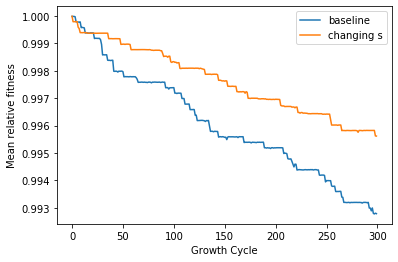

In [26]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(nGrowthCyc), experiment_results.mean(axis=0), label='baseline')
#plt.plot(np.arange(nGrowthCyc), mut_parts_experiment_results.mean(axis=0), label='changing mu')
plt.plot(np.arange(nGrowthCyc), sel_parts_experiment_results.mean(axis=0), label='changing s')
ax.set_xlabel('Growth Cycle')
ax.set_ylabel('Mean relative fitness')
plt.legend()

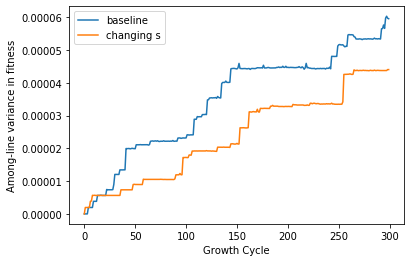

In [29]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(nGrowthCyc), experiment_results.std(axis=0)**2, label='baseline')
#plt.plot(np.arange(nGrowthCyc), mut_parts_experiment_results.std(axis=0)**2, label='changing mu')
plt.plot(np.arange(nGrowthCyc), sel_parts_experiment_results.std(axis=0)**2, label='changing s')
ax.set_xlabel('Growth Cycle')
ax.set_ylabel('Among-line variance in fitness')
plt.legend()

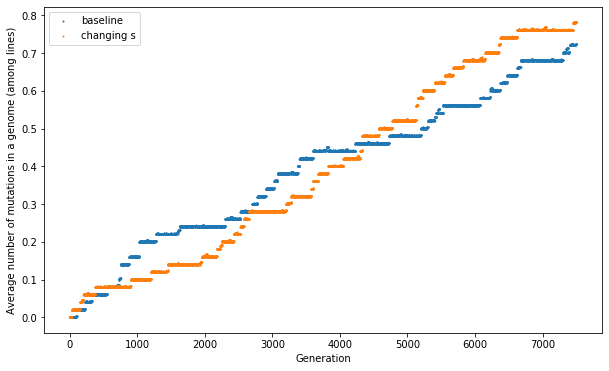

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))
#plt.errorbar(x=np.arange(sel_parts_average_muts.shape[1]), y=sel_parts_average_muts.mean(axis=0), 
#             yerr=sel_parts_average_muts.std(axis=0)**2, alpha=0.5, marker='s', ms=2, elinewidth=0.1)
plt.scatter(x=np.arange(average_muts.shape[1]), y=average_muts.mean(axis=0), s=1, label='baseline')
plt.scatter(x=np.arange(sel_parts_average_muts.shape[1]), y=sel_parts_average_muts.mean(axis=0), 
            s=1, label='changing s')
#plt.scatter(x=np.arange(sel_parts_average_muts.shape[1]), y=sel_parts_average_muts.mean(axis=0), s=1)
ax.set_xlabel('Generation')
ax.set_ylabel('Average number of mutations in a genome (among lines)')
plt.legend()

## Heterogeneity in mutation rates

In [38]:
sns.set(font_scale=1.4, style="whitegrid")

In [52]:
import glob
glob.glob('data/different_mus_experiment_mut_counts_mu1_*')

['data\\different_mus_experiment_mut_counts_mu1_0.0001_mu2_0.01.npy',
 'data\\different_mus_experiment_mut_counts_mu1_0.001_mu2_0.0001_s_0.001.npy',
 'data\\different_mus_experiment_mut_counts_mu1_0.001_mu2_0.0001_s_0.01.npy',
 'data\\different_mus_experiment_mut_counts_mu1_0.001_mu2_0.0001_s_0.1.npy',
 'data\\different_mus_experiment_mut_counts_mu1_0.01_mu2_0.0001_s_0.001.npy',
 'data\\different_mus_experiment_mut_counts_mu1_0.01_mu2_0.0001_s_0.01.npy',
 'data\\different_mus_experiment_mut_counts_mu1_0.01_mu2_0.0001_s_0.1.npy',
 'data\\different_mus_experiment_mut_counts_mu1_0.01_mu2_0.001_s_0.001.npy',
 'data\\different_mus_experiment_mut_counts_mu1_0.01_mu2_0.001_s_0.01.npy',
 'data\\different_mus_experiment_mut_counts_mu1_0.01_mu2_0.001_s_0.1.npy']

In [175]:
#different mus with stable s
mu1 = 0.01
mu2 = 0.0001
s = 0.001

experiment_results_mu1 = np.load(f'data/baseline_experiment_mu_{mu1}_s_{s}.npy')
average_muts_mu1 = np.load(f'data/baseline_experiment_mut_counts_mu_{mu1}_s_{s}.npy')
experiment_results_mu2 = np.load(f'data/baseline_experiment_mu_{mu2}_s_{s}.npy')
average_muts_mu2 = np.load(f'data/baseline_experiment_mut_counts_mu_{mu2}_s_{s}.npy')

mut_parts_experiment_results = np.load(f'data/different_mus_experiment_mu1_{mu1}_mu2_{mu2}_s_{s}.npy')
mut_parts_average_muts = np.load(f'data/different_mus_experiment_mut_counts_mu1_{mu1}_mu2_{mu2}_s_{s}.npy')
average_muts_part1 = np.load(f'data/different_mus_experiment_mut_counts_part1_mu1_{mu1}_mu2_{mu2}_s_{s}.npy')
average_muts_part2 = np.load(f'data/different_mus_experiment_mut_counts_part2_mu1_{mu1}_mu2_{mu2}_s_{s}.npy')
#sel_parts_experiment_results = np.load(f'data/different_s_experiment_s1_{s1}_s2_{s2}_mu_{mu}.npy')
#sel_parts_average_muts = np.load(f'data/different_s_experiment_mut_counts_s1_{s1}_s2_{s2}_mu_{mu}.npy')
#average_muts_part1_s1 = np.load(f'data/different_s_experiment_mut_counts_part1_s1_{s1}_s2_{s2}_mu_{mu}.npy')
#average_muts_part2_s2 = np.load(f'data/different_s_experiment_mut_counts_part2_s1_{s1}_s2_{s2}_mu_{mu}.npy')

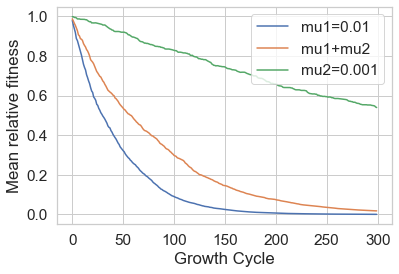

In [74]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(nGrowthCyc), experiment_results_mu1.mean(axis=0), label=f'mu1={mu1}')
plt.plot(np.arange(nGrowthCyc), mut_parts_experiment_results.mean(axis=0), label='mu1+mu2')
plt.plot(np.arange(nGrowthCyc), experiment_results_mu2.mean(axis=0), label=f'mu2={mu2}')
ax.set_xlabel('Growth Cycle')
ax.set_ylabel('Mean relative fitness')
plt.legend()
plt.savefig(f'pictures/different_mus_experiment_mut_counts_mu1_{mu1}_mu2_{mu2}_s_{s}_mean_fitness.png',  
            bbox_inches='tight', format='png')
plt.show()

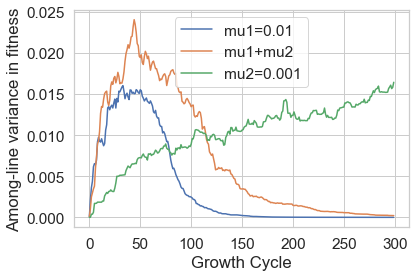

In [75]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(nGrowthCyc), experiment_results_mu1.std(axis=0)**2, label=f'mu1={mu1}')
plt.plot(np.arange(nGrowthCyc), mut_parts_experiment_results.std(axis=0)**2, label='mu1+mu2')
plt.plot(np.arange(nGrowthCyc), experiment_results_mu2.std(axis=0)**2, label=f'mu2={mu2}')
ax.set_xlabel('Growth Cycle')
ax.set_ylabel('Among-line variance in fitness')
plt.legend()
plt.savefig(f'pictures/different_mus_experiment_mut_counts_mu1_{mu1}_mu2_{mu2}_s_{s}_fitness_std.png',  
            bbox_inches='tight', format='png')
plt.show()

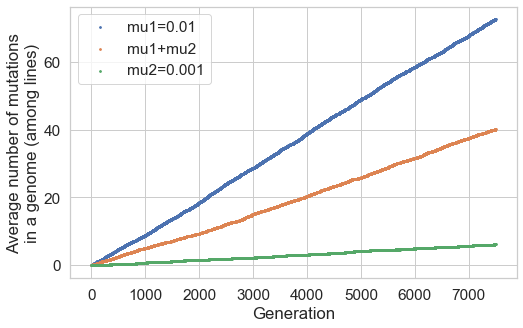

In [76]:
fig, ax = plt.subplots(figsize=(8, 5))
#plt.errorbar(x=np.arange(sel_parts_average_muts.shape[1]), y=sel_parts_average_muts.mean(axis=0), 
#             yerr=sel_parts_average_muts.std(axis=0)**2, alpha=0.5, marker='s', ms=2, elinewidth=0.1)
plt.scatter(x=np.arange(average_muts_mu1.shape[1]), y=average_muts_mu1.mean(axis=0), s=3, label=f'mu1={mu1}')
plt.scatter(x=np.arange(mut_parts_average_muts.shape[1]), y=mut_parts_average_muts.mean(axis=0), 
            s=3, label='mu1+mu2')
plt.scatter(x=np.arange(average_muts_mu2.shape[1]), y=average_muts_mu2.mean(axis=0), s=3, label=f'mu2={mu2}')
#plt.scatter(x=np.arange(sel_parts_average_muts.shape[1]), y=sel_parts_average_muts.mean(axis=0), s=1)
ax.set_xlabel('Generation')
ax.set_ylabel('Average number of mutations\nin a genome (among lines)')
plt.legend()
plt.savefig(f'pictures/different_mus_experiment_mut_counts_mu1_{mu1}_mu2_{mu2}_s_{s}_average_mut.png',  
            bbox_inches='tight', format='png')
plt.show()

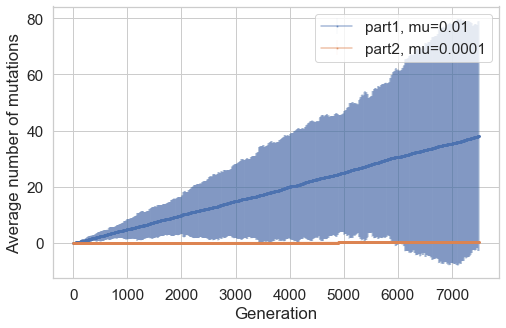

In [176]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.errorbar(x=np.arange(average_muts_part1.shape[1]), y=average_muts_part1.mean(axis=0), 
             yerr=average_muts_part1.std(axis=0)**2, alpha=0.5, marker='s', 
             ms=1, elinewidth=0.1, label=f'part1, mu={mu1}')
plt.errorbar(x=np.arange(average_muts_part2.shape[1]), y=average_muts_part2.mean(axis=0), 
             yerr=average_muts_part2.std(axis=0)**2, alpha=0.5, marker='s', 
             ms=1, elinewidth=0.1, label=f'part2, mu={mu2}')
ax.set_xlabel('Generation')
ax.set_ylabel('Average number of mutations')
plt.legend()
plt.savefig(f'pictures/different_mus_experiment_mut_counts_mu1_{mu1}_mu2_{mu2}_s_{s}_2_parts.png',  
            bbox_inches='tight', format='png')
plt.show()

## Heterogeneity in selection

In [11]:
nGrowthCyc = 300

In [77]:
glob.glob('data/different_s_experiment_s1_*')

['data\\different_s_experiment_s1_0.001_s2_0.01.npy',
 'data\\different_s_experiment_s1_0.01_s2_0.001_mu_0.0001.npy',
 'data\\different_s_experiment_s1_0.01_s2_0.001_mu_0.001.npy',
 'data\\different_s_experiment_s1_0.01_s2_0.001_mu_0.01.npy',
 'data\\different_s_experiment_s1_0.1_s2_0.001_mu_0.0001.npy',
 'data\\different_s_experiment_s1_0.1_s2_0.001_mu_0.001.npy',
 'data\\different_s_experiment_s1_0.1_s2_0.001_mu_0.01.npy',
 'data\\different_s_experiment_s1_0.1_s2_0.01_mu_0.0001.npy',
 'data\\different_s_experiment_s1_0.1_s2_0.01_mu_0.001.npy',
 'data\\different_s_experiment_s1_0.1_s2_0.01_mu_0.01.npy']

In [198]:
#different s with stable mu
mu = 0.01
s1 = 0.1
s2 = 0.01

experiment_results_s1 = np.load(f'data/baseline_experiment_mu_{mu}_s_{s1}.npy')
average_muts_s1 = np.load(f'data/baseline_experiment_mut_counts_mu_{mu}_s_{s1}.npy')
experiment_results_s2 = np.load(f'data/baseline_experiment_mu_{mu}_s_{s2}.npy')
average_muts_s2 = np.load(f'data/baseline_experiment_mut_counts_mu_{mu}_s_{s2}.npy')

#mut_parts_experiment_results = np.load(f'data/different_mus_experiment_mu1_{mu1}_mu2_{mu2}_s_{s}.npy')
#mut_parts_average_muts = np.load(f'data/different_mus_experiment_mut_counts_mu1_{mu1}_mu2_{mu2}_s_{s}.npy')
#average_muts_part1 = np.load(f'data/different_mus_experiment_mut_counts_part1_mu1_{mu1}_mu2_{mu2}_s_{s}.npy')
#average_muts_part2 = np.load(f'data/different_mus_experiment_mut_counts_part2_mu1_{mu1}_mu2_{mu2}_s_{s}.npy')
sel_parts_experiment_results = np.load(f'data/different_s_experiment_s1_{s1}_s2_{s2}_mu_{mu}.npy')
sel_parts_average_muts = np.load(f'data/different_s_experiment_mut_counts_s1_{s1}_s2_{s2}_mu_{mu}.npy')
average_muts_part1_s1 = np.load(f'data/different_s_experiment_mut_counts_part1_s1_{s1}_s2_{s2}_mu_{mu}.npy')
average_muts_part2_s2 = np.load(f'data/different_s_experiment_mut_counts_part2_s1_{s1}_s2_{s2}_mu_{mu}.npy')

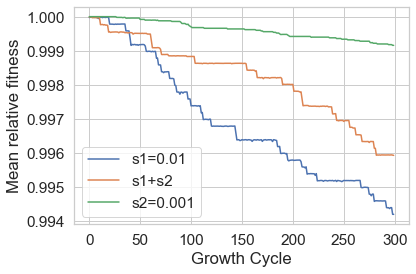

In [121]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(nGrowthCyc), experiment_results_s1.mean(axis=0), label=f's1={s1}')
plt.plot(np.arange(nGrowthCyc), sel_parts_experiment_results.mean(axis=0), label='s1+s2')
plt.plot(np.arange(nGrowthCyc), experiment_results_s2.mean(axis=0), label=f's2={s2}')
ax.set_xlabel('Growth Cycle')
ax.set_ylabel('Mean relative fitness')
plt.savefig(f'pictures/different_s_experiment_s1_{s1}_s2_{s2}_mu_{mu}_mean_fitness.png',  
            bbox_inches='tight', format='png')
plt.legend()
plt.savefig(f'pictures/different_s_experiment_s1_{s1}_s2_{s2}_mu_{mu}_mean_fitness.png',  
            bbox_inches='tight', format='png')
plt.show()

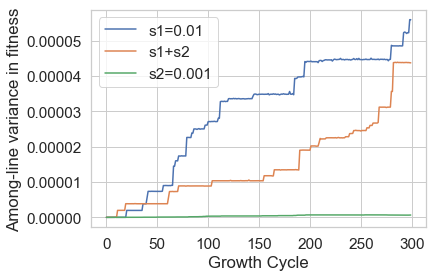

In [122]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(nGrowthCyc), experiment_results_s1.std(axis=0)**2, label=f's1={s1}')
plt.plot(np.arange(nGrowthCyc), sel_parts_experiment_results.std(axis=0)**2, label='s1+s2')
plt.plot(np.arange(nGrowthCyc), experiment_results_s2.std(axis=0)**2, label=f's2={s2}')
ax.set_xlabel('Growth Cycle')
ax.set_ylabel('Among-line variance in fitness')
plt.legend()
plt.savefig(f'pictures/different_s_experiment_s1_{s1}_s2_{s2}_mu_{mu}_fitness_std.png',  
            bbox_inches='tight', format='png')
plt.show()

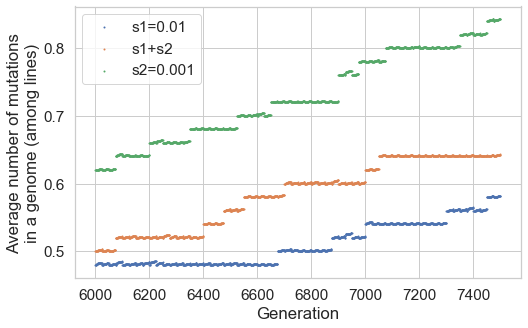

In [123]:
fig, ax = plt.subplots(figsize=(8, 5))
#plt.errorbar(x=np.arange(sel_parts_average_muts.shape[1]), y=sel_parts_average_muts.mean(axis=0), 
#             yerr=sel_parts_average_muts.std(axis=0)**2, alpha=0.5, marker='s', ms=2, elinewidth=0.1)
plt.scatter(x=np.arange(average_muts_s1.shape[1])[6000:], y=average_muts_s1.mean(axis=0)[6000:], s=1, 
            label=f's1={s1}')
plt.scatter(x=np.arange(sel_parts_average_muts.shape[1])[6000:], y=sel_parts_average_muts.mean(axis=0)[6000:], 
            s=1, label='s1+s2')
plt.scatter(x=np.arange(average_muts_s2.shape[1])[6000:], y=average_muts_s2.mean(axis=0)[6000:], s=1, 
            label=f's2={s2}')
#plt.scatter(x=np.arange(sel_parts_average_muts.shape[1]), y=sel_parts_average_muts.mean(axis=0), s=1)
ax.set_xlabel('Generation')
ax.set_ylabel('Average number of mutations\nin a genome (among lines)')
plt.legend()
plt.savefig(f'pictures/different_s_experiment_s1_{s1}_s2_{s2}_mu_{mu}_average_mut_zoomed.png',  
            bbox_inches='tight', format='png')
plt.show()

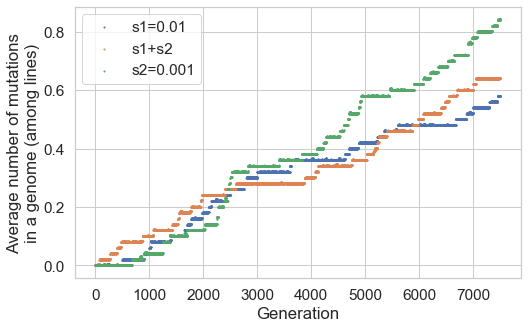

In [124]:
fig, ax = plt.subplots(figsize=(8, 5))
#plt.errorbar(x=np.arange(sel_parts_average_muts.shape[1]), y=sel_parts_average_muts.mean(axis=0), 
#             yerr=sel_parts_average_muts.std(axis=0)**2, alpha=0.5, marker='s', ms=2, elinewidth=0.1)
plt.scatter(x=np.arange(average_muts_s1.shape[1]), y=average_muts_s1.mean(axis=0), s=1, 
            label=f's1={s1}')
plt.scatter(x=np.arange(sel_parts_average_muts.shape[1]), y=sel_parts_average_muts.mean(axis=0), 
            s=1, label='s1+s2')
plt.scatter(x=np.arange(average_muts_s2.shape[1]), y=average_muts_s2.mean(axis=0), s=1, label=f's2={s2}')
#plt.scatter(x=np.arange(sel_parts_average_muts.shape[1]), y=sel_parts_average_muts.mean(axis=0), s=1)
ax.set_xlabel('Generation')
ax.set_ylabel('Average number of mutations\nin a genome (among lines)')
plt.legend()
plt.savefig(f'pictures/different_s_experiment_s1_{s1}_s2_{s2}_mu_{mu}_average_mut.png',  
            bbox_inches='tight', format='png')
plt.show()

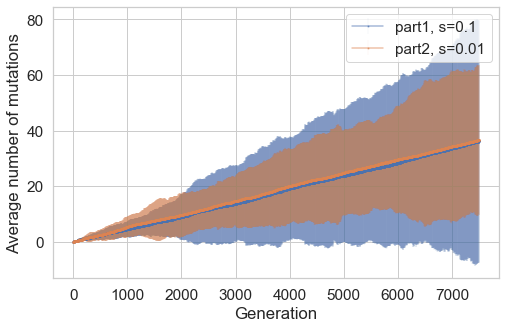

In [199]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.errorbar(x=np.arange(average_muts_part1_s1.shape[1]), y=average_muts_part1_s1.mean(axis=0), 
             yerr=average_muts_part1_s1.std(axis=0)**2, alpha=0.5, marker='s', 
             ms=1, elinewidth=0.1, label=f'part1, s={s1}')
plt.errorbar(x=np.arange(average_muts_part2_s2.shape[1]), y=average_muts_part2_s2.mean(axis=0), 
             yerr=average_muts_part2_s2.std(axis=0)**2, alpha=0.5, marker='s', 
             ms=1, elinewidth=0.1, label=f'part2, s={s2}')
ax.set_xlabel('Generation')
ax.set_ylabel('Average number of mutations')
plt.legend()
plt.savefig(f'pictures/different_s_experiment_s1_{s1}_s2_{s2}_mu_{mu}_2_parts.png',  
            bbox_inches='tight', format='png')
plt.show()

In [200]:
mu1 = 0.001
mu2 = 0.0001
s1 = 0.1
s2 = 0.01

#experiment_results_s1 = np.load(f'data/baseline_experiment_mu_{mu}_s_{s1}.npy')
#average_muts_s1 = np.load(f'data/baseline_experiment_mut_counts_mu_{mu}_s_{s1}.npy')
#experiment_results_s2 = np.load(f'data/baseline_experiment_mu_{mu}_s_{s2}.npy')
#average_muts_s2 = np.load(f'data/baseline_experiment_mut_counts_mu_{mu}_s_{s2}.npy')

#mut_parts_experiment_results = np.load(f'data/different_mus_experiment_mu1_{mu1}_mu2_{mu2}_s_{s}.npy')
#mut_parts_average_muts = np.load(f'data/different_mus_experiment_mut_counts_mu1_{mu1}_mu2_{mu2}_s_{s}.npy')
average_muts_part1 = np.load(f'data/different_mus_experiment_mut_counts_part1_mu1_{mu1}_mu2_{mu2}_s_{s1}.npy')
average_muts_part2 = np.load(f'data/different_mus_experiment_mut_counts_part2_mu1_{mu1}_mu2_{mu2}_s_{s1}.npy')
#sel_parts_experiment_results = np.load(f'data/different_s_experiment_s1_{s1}_s2_{s2}_mu_{mu}.npy')
#sel_parts_average_muts = np.load(f'data/different_s_experiment_mut_counts_s1_{s1}_s2_{s2}_mu_{mu}.npy')
average_muts_part1_s1 = np.load(f'data/different_s_experiment_mut_counts_part1_s1_{s1}_s2_{s2}_mu_{mu1}.npy')
average_muts_part2_s2 = np.load(f'data/different_s_experiment_mut_counts_part2_s1_{s1}_s2_{s2}_mu_{mu1}.npy')

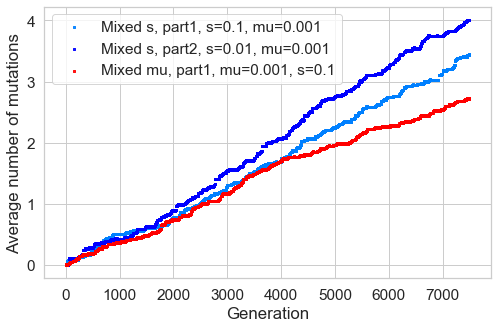

In [208]:
fig, ax = plt.subplots(figsize=(8, 5))
#plt.errorbar(x=np.arange(average_muts_part1_s1.shape[1]), y=average_muts_part1_s1.mean(axis=0), 
#             yerr=average_muts_part1_s1.std(axis=0)**2, alpha=0.5, marker='s', 
#             ms=1, elinewidth=0.1, label=f'part1, s={s1}')
#plt.errorbar(x=np.arange(average_muts_part2_s2.shape[1]), y=average_muts_part2_s2.mean(axis=0), 
#             yerr=average_muts_part2_s2.std(axis=0)**2, alpha=0.5, marker='s', 
#             ms=1, elinewidth=0.1, label=f'part2, s={s2}')
plt.scatter(x=np.arange(average_muts_part1_s1.shape[1]), y=average_muts_part1_s1.mean(axis=0), 
             alpha=0.9, marker='s', 
             s=5, label=f'Mixed s, part1, s={s1}, mu={mu1}', color='#0080FF')
plt.scatter(x=np.arange(average_muts_part2_s2.shape[1]), y=average_muts_part2_s2.mean(axis=0), 
             alpha=0.9, marker='s', 
             s=5, label=f'Mixed s, part2, s={s2}, mu={mu1}', color='#0000FF')
plt.scatter(x=np.arange(average_muts_part1.shape[1]), y=average_muts_part1.mean(axis=0), 
             alpha=0.9, marker='s', 
             s=5, label=f'Mixed mu, part1, mu={mu1}, s={s1}', color='#ff0000')
#plt.scatter(x=np.arange(average_muts_part2.shape[1]), y=average_muts_part2.mean(axis=0), 
#             alpha=0.9, marker='s', 
#             s=5, label=f'Mixed mu, part2, mu={mu2}, s={s1}', color='#ff8000')
ax.set_xlabel('Generation')
ax.set_ylabel('Average number of mutations')
plt.legend()
plt.savefig(f'pictures/comparison_of_mixed_s1_{s1}_s2_{s2}_mu_{mu1}.png',  
            bbox_inches='tight', format='png')
plt.show()

In [157]:
4/7500

0.0005333333333333334

# Numpy arrays to dataframes (saving data) 

In [23]:
mu = 0.0001
s1 = 0.01
s2 = 0.001

In [24]:
experiment_results_s1 = np.load(f'data/baseline_experiment_mu_{mu}_s_{s1}.npy')
average_muts_s1 = np.load(f'data/baseline_experiment_mut_counts_mu_{mu}_s_{s1}.npy')
experiment_results_s2 = np.load(f'data/baseline_experiment_mu_{mu}_s_{s2}.npy')
average_muts_s2 = np.load(f'data/baseline_experiment_mut_counts_mu_{mu}_s_{s2}.npy')

#mut_parts_experiment_results = np.load(f'data/different_mus_experiment_mu1_{mu1}_mu2_{mu2}_s_{s}.npy')
#mut_parts_average_muts = np.load(f'data/different_mus_experiment_mut_counts_mu1_{mu1}_mu2_{mu2}_s_{s}.npy')
#average_muts_part1 = np.load(f'data/different_mus_experiment_mut_counts_part1_mu1_{mu1}_mu2_{mu2}_s_{s}.npy')
#average_muts_part2 = np.load(f'data/different_mus_experiment_mut_counts_part2_mu1_{mu1}_mu2_{mu2}_s_{s}.npy')
sel_parts_experiment_results = np.load(f'data/different_s_experiment_s1_{s1}_s2_{s2}_mu_{mu}.npy')
sel_parts_average_muts = np.load(f'data/different_s_experiment_mut_counts_s1_{s1}_s2_{s2}_mu_{mu}.npy')
average_muts_part1_s1 = np.load(f'data/different_s_experiment_mut_counts_part1_s1_{s1}_s2_{s2}_mu_{mu}.npy')
average_muts_part2_s2 = np.load(f'data/different_s_experiment_mut_counts_part2_s1_{s1}_s2_{s2}_mu_{mu}.npy')

In [25]:
experiment_results_s1.shape

(50, 300)

In [32]:
df = pd.DataFrame(experiment_results_s1.T, 
                  columns=[f'line_{i}' for i in range(1, 51)], 
                  index=[f'GC_{j}' for j in range(1, 301)])

In [33]:
df['Growth Cycle'] = df.index

In [34]:
df

,line_1,line_2,line_3,line_4,line_5,line_6,line_7,line_8,line_9,line_10,...,line_42,line_43,line_44,line_45,line_46,line_47,line_48,line_49,line_50,Growth Cycle
GC_1,0.999993,0.999991,0.999980,0.999985,0.999990,0.999991,0.999984,0.999972,0.999987,0.999983,...,0.999992,0.999986,0.999831,0.999985,0.999978,0.999980,0.999981,0.999981,0.999988,GC_1
GC_2,0.999969,0.999989,0.999985,0.999987,0.999988,0.999983,0.999962,0.999989,0.999984,0.999970,...,0.999985,0.999991,0.999980,0.999982,0.999969,0.999983,0.999987,0.999981,0.999992,GC_2
GC_3,0.999987,0.999979,0.999982,0.999977,0.999976,0.999988,0.999981,0.999983,0.999988,0.999972,...,0.999972,0.999985,0.999986,0.999984,0.999981,0.999991,0.999974,0.999988,0.999985,GC_3
GC_4,0.999980,0.999974,0.999991,0.999992,0.999988,0.999977,0.999982,0.999981,0.999992,0.999950,...,0.999987,0.999996,0.999973,0.999989,0.999977,0.999979,0.999979,0.999992,0.999988,GC_4
GC_5,0.999991,0.999983,0.999970,0.999982,0.999980,0.999985,0.999984,0.999987,0.999990,0.999983,...,0.999960,0.999979,0.999989,0.999989,0.999974,0.999987,0.999986,0.999991,0.999982,GC_5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GC_296,0.989987,0.980093,0.999994,0.980024,0.980090,0.999986,0.980075,0.980057,0.989989,0.998767,...,0.999975,0.989984,0.999976,0.989986,0.989988,0.999961,0.989987,0.999992,0.999978,GC_296
GC_297,0.989985,0.980082,0.999982,0.980063,0.980088,0.999978,0.980086,0.980076,0.989984,0.999991,...,0.999977,0.989990,0.999984,0.989985,0.989988,0.999993,0.989988,0.999987,0.999978,GC_297
GC_298,0.989955,0.980090,0.999992,0.980077,0.980080,0.999990,0.980081,0.980089,0.989988,0.999990,...,0.999993,0.989986,0.999988,0.989985,0.989989,0.999973,0.989984,0.999980,0.999988,GC_298
GC_299,0.989983,0.980077,0.999979,0.980088,0.980082,0.999987,0.980081,0.980084,0.989985,0.999992,...,0.999971,0.989980,0.999989,0.989991,0.989990,0.999978,0.980076,0.999981,0.999990,GC_299


# Sanity checks

Technical staff, delete these later

In [ ]:
exp = experiment(mu=1e-4, s=0.01)
exp.evolve(nGrowthCyc=300, nDivPerCyc=nDivPerCyc)

In [ ]:
#plot growth curve
plt.plot(exp.pop_size[0:25])

In [7]:
#pseudo-partition with the same mutation rate
%%time
experiment_results_test = []
average_muts_test = []
#we run a separate experiment for each line and remember the fitness measurements
for line in tqdm(range(nLines)):
    exp = experiment(mu1=1e-4, mu2=1e-4, s=0.01)
    exp.evolve(nGrowthCyc=300, nDivPerCyc=nDivPerCyc)
    #we save fitness measurements for each line at each growth cycle
    experiment_results_test.append(exp.gc_fitness)
    #save genotypes numbers
    #line_genotypes[line] = exp.genotypes_history
    average_muts_test.append(exp.genotypes_history)
experiment_results_test = np.array(experiment_results_test)
average_muts_test = np.array(average_muts_test)


Wall time: 15min 31s


Text(0, 0.5, 'Mean relative fitness')

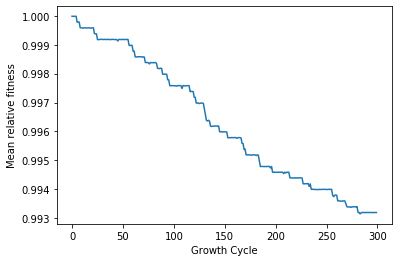

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(nGrowthCyc), experiment_results_test.mean(axis=0))
ax.set_xlabel('Growth Cycle')
ax.set_ylabel('Mean relative fitness')

Text(0, 0.5, 'Among-line variance in fitness')

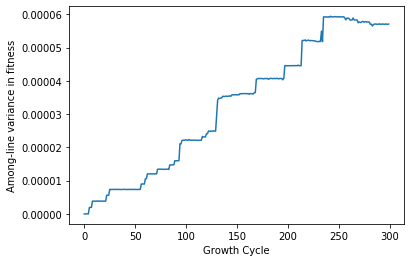

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(nGrowthCyc), experiment_results_test.std(axis=0)**2)
ax.set_xlabel('Growth Cycle')
ax.set_ylabel('Among-line variance in fitness')

In [9]:
#pseudo-partition with the same s
%%time
experiment_results_test2 = []
average_muts_test2 = []
#we run a separate experiment for each line and remember the fitness measurements
for line in tqdm(range(nLines)):
    exp = experiment(mu=1e-4, s1=0.01, s2=0.01)
    exp.evolve(nGrowthCyc=300, nDivPerCyc=nDivPerCyc)
    #we save fitness measurements for each line at each growth cycle
    experiment_results_test2.append(exp.gc_fitness)
    #save genotypes numbers
    #line_genotypes[line] = exp.genotypes_history
    average_muts_test2.append(exp.genotypes_history)
experiment_results_test2 = np.array(experiment_results_test2)
average_muts_test2 = np.array(average_muts_test2)


Wall time: 17min 7s


Text(0, 0.5, 'Mean relative fitness')

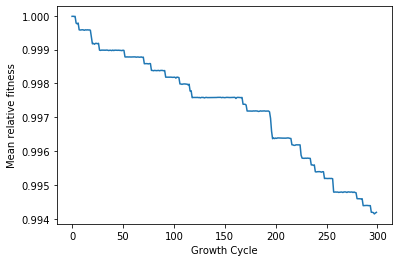

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(nGrowthCyc), experiment_results_test2.mean(axis=0))
ax.set_xlabel('Growth Cycle')
ax.set_ylabel('Mean relative fitness')

Text(0, 0.5, 'Among-line variance in fitness')

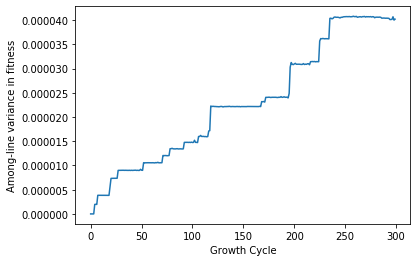

In [12]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(nGrowthCyc), experiment_results_test2.std(axis=0)**2)
ax.set_xlabel('Growth Cycle')
ax.set_ylabel('Among-line variance in fitness')

In [145]:
#with open(f'clean_data/mut_counts_mu_{mu}_s_{s}.csv', 'w') as f:
#    f.write(f'line,GC,DivCyc,genotype,counts\n')
#    counter = 0
#    for line_freq in mut_freq:
#        for e in line_freq:
#            gc, divcyc, gen, counts = e
#            for i in range(len(gen)):
#                f.write(f'line{counter},{gc},{divcyc},{gen[i]},{counts[i]}\n')
#        counter += 1

In [147]:
#trying to reproduce the result from the original paper
V_r = 0.0003/300
R_r = 0.02/300

In [148]:
R_r**2/V_r, V_r/R_r

(0.004444444444444445, 0.015)

In [158]:
C_r = 0.25
Cv = 2*18.41

In [159]:
(R_r**2*(1 - C_r))/(V_r*(1 + Cv/2))

0.00017173278378842524

In [160]:
R**2*(1 - C_r))/(V*(1 + Cv/2)), V_r/(R_r*(1+C_r))

0.011999999999999999

# References

1. The Lower Bound to the Evolution of Mutation Rates (https://doi.org/10.1093/gbe/evr066). Paper with population simulations described in details
2. Genetic drift, selection and the evolution of the mutation rate. https://www.nature.com/articles/nrg.2016.104. Main paper, the review about mutation rate evolution
3. https://github.com/SasankYadati/wright-fisher-population-genetics-simulation - github with Wright-Fisher simple model, this code is partially based on it.
4. Estimate of the genomic mutation rate deleterious to overall fitness in E. coli. https://www.nature.com/articles/381694a0. The paper with mutation accumulation experiment description.
5. https://www.pnas.org/doi/pdf/10.1073/pnas.96.20.11393